# Introduction

The purpose of this notebook is to create a shortlist of clincial variables from the UKBB for involvement in a multimodal model for glaucoma risk prediction.
The method of clinical variable selection is loosely based off Dabbah (2021).

This will involve the following steps:
- Separate out a final test set for validating the final model
- Identifying all the fields present in the UKBB by reading through the HTML documentation
- Removing any fields that are difficult to deal with or have few responses
- Removing any fields that were not taken at the initial assessment
- Defining glaucoma (using the same definition as MacGregor (2018))
- Expanding out ICD10 diagnoses into a table. Only count diagnoses that were from 2010 and earlier.
- Expand out the two self-reported illness tables. Only count diagnoses from 2010 and earlier.
- Expand out medication fields - only use the first set of medication fields from 2010 and earlier.
- Filter out all patients who had glaucoma diagnosed 2010 and earlier, and glaucoma cases with no diagnosis date.
- Cleaning columns so they can be used in models. No dummy variables to be used as these do not work as well with random forest models.
- Train random forests
- Rank features
- Exclude collinear features
- Review each feature and exclude those with the following characteristics:
  - Features that cannot be obtained by self-reporting or in the clincial setting
  - High confounding with higher ranked features
  - The high ranking of the feature is likely due to database bias
  - The feature is highly ranked as consequence of glaucoma treatment

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from collections import Counter
from matplotlib_venn import venn2, venn3
from scipy import stats
from tableone import TableOne
import statsmodels.api as sm
from bs4 import BeautifulSoup
import re
import seaborn as sns
import scipy
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
warnings.simplefilter('ignore')
import time
import scipy.sparse
from joblib import dump, load
import statsmodels

In [2]:
UKBB_PATH = '../glaucoma_project/UKBB_Data/'
MAIN_UKBB_FILE = '../glaucoma_project/UKBB_Data/ukb49508.tab'
SECOND_UKBB_FILE = '../glaucoma_project/UKBB_Data_Basket3/ukb51745.tab'
MAIN_HTML_FILE = '../glaucoma_project/UKBB_Data/ukb49508.html'
SECOND_HTML_FILE = '../glaucoma_project/UKBB_Data_Basket3/ukb51745.html'
TOTAL_POP = 502419
TEST_SET_RANDOM_SPLIT = 42
CHUNK_SIZE = 10000

# Creating a test set

Separate out the 10% of the dataset for testing the final model model

In [3]:
train_idx, test_idx = train_test_split(range(TOTAL_POP),random_state=TEST_SET_RANDOM_SPLIT, test_size=0.1)

Method for loading data -- due to the large size of the dataset we can only load a few columns at once, and these should be specified.
Chunk the data into pieces and load one piece at a time.

Also selects only the train set indices by default. Is able to select the test set indices as well.

In [4]:
def get_dataframe_for_analysis(column_names, idx=train_idx):
    print('Preparing dataframe...')
    
    cols_in_main_file = pd.read_csv(MAIN_UKBB_FILE, sep='\t', nrows=1).columns
    cols_in_second_file = pd.read_csv(SECOND_UKBB_FILE, sep='\t', nrows=1).columns
    column_names_main = [col for col in column_names if col in cols_in_main_file]
    column_names_second = [col for col in column_names if (not col in cols_in_main_file) and (col in cols_in_second_file)]
    
    
    df_selected_cols = pd.DataFrame()
    for chunk in tqdm(pd.read_csv(MAIN_UKBB_FILE, sep='\t', chunksize=CHUNK_SIZE, usecols=column_names_main+['f.eid']), total=TOTAL_POP // CHUNK_SIZE):
        df_selected_cols = pd.concat([df_selected_cols, chunk])
        
    df_selected_cols_second = pd.DataFrame()
    for chunk in tqdm(pd.read_csv(SECOND_UKBB_FILE, sep='\t', chunksize=CHUNK_SIZE, usecols=column_names_second+['f.eid']), total=TOTAL_POP // CHUNK_SIZE):
        df_selected_cols_second = pd.concat([df_selected_cols_second, chunk])
    
    return pd.merge(df_selected_cols,df_selected_cols_second,how='left',on='f.eid').iloc[idx].reset_index(drop=True)

# Identifying fields present in UKBB

Open the UKBB HTML files

In [5]:
file = open(MAIN_HTML_FILE, 'r', encoding='latin-1')
html_file = file.read()
soup = BeautifulSoup(html_file, "html.parser")
tables = soup.find_all('table')
rows_main = tables[1].find_all('tr')

In [6]:
file = open(SECOND_HTML_FILE, 'r', encoding='latin-1')
html_file = file.read()
soup = BeautifulSoup(html_file, "html.parser")
tables = soup.find_all('table')
rows_second = tables[1].find_all('tr')

In [7]:
rows = rows_main + rows_second

Putting everything into df_fields

In [8]:
df_fields = pd.DataFrame()
fields = []
count = []
types = []
desc = []
current_type = None
current_desc = None
for row in rows:
    row_content = row.find_all('td')
    if len(row_content) > 2:
        fields.append(row_content[1].text.strip())
        count.append(row_content[2].text.strip())
        if len(row_content) > 4:
            current_type = row_content[3].text.strip()
            current_desc = row_content[4].text.strip()
        types.append(current_type)
        desc.append(current_desc)
        
df_fields['UDI'] = fields
df_fields['Count'] = [int(n) for n in count]
df_fields['Type'] = types
df_fields['Desc'] = desc
df_fields['Dating coding'] = df_fields['Desc'].apply(lambda x: re.sub('[^0-9]','', x[x.index('data-coding '):x.index(' comprises')]) if 'data-coding' in x else np.nan)
df_fields['Valued members'] = df_fields['Desc'].apply(lambda x: int(re.sub('[^0-9]','', x[x.index('comprises '):x.index('valued members')])) if 'data-coding' in x else np.nan)
df_fields['Field ID'] = df_fields['UDI'].apply(lambda x: 'f.'+re.sub('-','.',x))
df_fields['Desc Short'] = df_fields['Desc'].apply(lambda x: x[0:x.index('Uses data-coding')] if 'Uses data-coding' in x else x)

Creating a unique description identifier for each field - successive measurements of the same variable will have numbers appended to the end

In [9]:
desc_unique = []
prev_desc = None
counter = 0
for desc in df_fields['Desc Short']:
    if prev_desc == desc:
        if counter == 0:
            desc_unique[-1] = desc+'_0'
        counter += 1
        desc_unique.append(desc+'_'+str(counter))
    else:
        counter = 0
        prev_desc = desc
        desc_unique.append(desc)
df_fields['Desc Unique'] = desc_unique

Create some useful dictionaries

In [10]:
# Field ID to description 
id_to_desc = {id_:desc for id_,desc in zip(df_fields['Field ID'], df_fields['Desc Unique'])}
# Description to field ID
desc_to_id = {desc:id_ for desc,id_ in zip(df_fields['Desc Unique'], df_fields['Field ID'])}
# Field ID to field type
id_to_type = {id_:type_ for id_,type_ in zip(df_fields['Field ID'], df_fields['Type'])}

In [11]:
df_fields = df_fields.drop_duplicates('UDI').reset_index(drop=True)

In [12]:
coding_dicts = []
for df_coding in [pd.read_csv(UKBB_PATH+'UKBB_encodings/coding19.tsv', sep='\t'),
                  pd.read_csv(UKBB_PATH+'UKBB_encodings/coding3.tsv', sep='\t'),
                  pd.read_csv(UKBB_PATH+'UKBB_encodings/coding6.tsv', sep='\t'),
                  pd.read_csv(UKBB_PATH+'UKBB_encodings/coding4.tsv', sep='\t')]:
    coding_dicts.append({code:meaning for code,meaning in zip(df_coding['coding'], df_coding['meaning'])})

In [13]:
def feature_id_to_name(feature_id):
    if 'f.' in feature_id:
        if '_' in feature_id:
            return id_to_desc[feature_id[:feature_id.find('_')]] + feature_id[feature_id.find('_'):]
        else:
            return id_to_desc[feature_id]
    if 'ICD_10_' in feature_id:
        return coding_dicts[0][feature_id[7:]]
    if 'Self_Report_' in feature_id:
        return coding_dicts[2][int(feature_id[12:-2])]
    if 'Cancer_' in feature_id:
        return coding_dicts[1][int(feature_id[7:-2])]
    if 'Med_' in feature_id:
        return coding_dicts[3][int(feature_id[4:-2])]
    return 'FEATURE NOT FOUND'

# Initial field selection

In [14]:
df_selected_fields = df_fields.copy()

In [15]:
df_fields['Type'].value_counts()

Categorical (single)      4751
Continuous                4318
Integer                   4066
Categorical (multiple)    2948
Text                      1401
Date                       719
Time                       181
Curve                       32
Sequence                     1
Name: Type, dtype: int64

There are a number of fields here that are likely not easily usable. Filter to only include fields with categorical or numeric variables.

In [17]:
df_selected_fields = df_selected_fields[df_selected_fields['Type'].apply(lambda x: x in ['Categorical (single)','Continuous','Integer','Categorical (multiple)'])].copy()

In [18]:
len(df_selected_fields)

16083

Just take the first value of each field. For most clinical variables, we're not going to consider repeated measurements.

In [19]:
df_selected_fields = df_selected_fields.drop_duplicates('Desc')

In [20]:
len(df_selected_fields)

3267

Remove all fields with more than 50 valued members (possible values). Some of these fields (e.g. diagnoses) will be considered separately.

In [21]:
df_selected_fields = df_selected_fields[~(df_selected_fields['Valued members'] > 50)].copy()

Remove fields with less than 1000 entries.

In [22]:
df_selected_fields = df_selected_fields[df_selected_fields['Count'] >= 1000].copy()

Remove fields with less than 1000 entries.

In [23]:
df_selected_fields = df_selected_fields[df_selected_fields['Field ID'].apply(lambda x: int(x.split('.')[2])) == 0].copy()

Removed fields that weren't taken at baseline

In [24]:
df_selected_fields = df_selected_fields[~df_selected_fields['Desc Short'].apply(lambda x: 'pilot' in x)].copy()

Exclude pilot fields

In [25]:
len(df_selected_fields)

2007

2007 fields in total

# Defining Glaucoma

Defining glaucoma as per MacGregor (2018)

Using the following columns:
- Non-cancer illness code, self-reported (20002)
- Diagnoses - ICD10 (41270)
- Diagnoses - ICD9 (41271)
- Eye problems/disorders (6148) via touchscreen

In [19]:
glaucoma_diagnosis_columns = [column for column in df_fields['Field ID'] if '20002' in column or '41270' in column or '41271' in column or '6148' in column]

In [41]:
touchscreen_cols = [id_to_desc[col] for col in glaucoma_diagnosis_columns if '6148' in col]
self_reported_cols = [id_to_desc[col] for col in glaucoma_diagnosis_columns if '20002' in col]
icd10_cols = [id_to_desc[col] for col in glaucoma_diagnosis_columns if '41270' in col]
icd9_cols = [id_to_desc[col] for col in glaucoma_diagnosis_columns if '41271' in col]

In [42]:
df_glaucoma_data = get_dataframe_for_analysis(glaucoma_diagnosis_columns)

Preparing dataframe...


51it [11:59, 14.11s/it]                                                                               


Rename columns to be more descriptive

In [43]:
df_glaucoma_data.columns = [id_to_desc[column] for column in df_glaucoma_data.columns]

Method to see if a particular diagnosis is present in a set of columns.
- codes: the code to look for
- key_word: filter columns by this keyword when looking for codes
- df_columns: the relevant dataset

Will output one column for each code requested

In [44]:
def patient_has_diagnosis(codes,key_word, df_columns):
    # get only the columns that have key_word in them (e.g. selected ICD10 diagnoses only)
    diagnoses_columns = [column for column in df_columns.columns if key_word in column]
    df_relevant_columns = df_columns[diagnoses_columns]
    
    # each column in this correspond to columns in df_relevant_columns, saying which codes are present
    df_codes_present = pd.DataFrame()
    
    for column in tqdm(diagnoses_columns):
        df_codes_present[column] = df_relevant_columns[column].apply(lambda x: [code in str(x) for code in codes])
    
    # columns in this correspond to codes - whether or not codes are present
    df_output_columns = pd.DataFrame()
    for i in tqdm(range(len(codes))):
        df_output_columns[codes[i]] = [False]*len(df_columns)
        for column in df_codes_present.columns:
            df_output_columns[codes[i]] = df_output_columns[codes[i]] | df_codes_present[column].apply(lambda x: x[i])
            
    return df_output_columns

Extract ICD10 information

In [45]:
icd10_column_names = ['ICD10 POAG','ICD10 Other glaucoma','ICD10 Glaucoma unspecified']
icd10_codes = ['H401','H408','H409']

In [46]:
df_icd_10 = patient_has_diagnosis(icd10_codes,'Diagnoses - ICD10',df_glaucoma_data)

100%|███████████████████████████████████████████████████████████████████| 3/3 [00:46<00:00, 15.55s/it]


In [47]:
for column_name, code in zip(icd10_column_names, icd10_codes):
    df_glaucoma_data[column_name] = df_icd_10[code]
    print(df_glaucoma_data[column_name].value_counts())

False    449150
True       3027
Name: ICD10 POAG, dtype: int64
False    452012
True        165
Name: ICD10 Other glaucoma, dtype: int64
False    444959
True       7218
Name: ICD10 Glaucoma unspecified, dtype: int64


Extract ICD9 information

In [48]:
icd9_column_names = ['ICD9 POAG', 'ICD9 Other glaucoma','ICD9 Glaucoma unspecified']
icd9_codes = ['3651','3658','3659']

In [49]:
df_icd_9 = patient_has_diagnosis(icd9_codes,'Diagnoses - ICD9',df_glaucoma_data)

100%|███████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.12s/it]


In [50]:
for column_name, code in zip(icd9_column_names, icd9_codes):
    df_glaucoma_data[column_name] = df_icd_9[code]
    print(df_glaucoma_data[column_name].value_counts())

False    452170
True          7
Name: ICD9 POAG, dtype: int64
False    452177
Name: ICD9 Other glaucoma, dtype: int64
False    452156
True         21
Name: ICD9 Glaucoma unspecified, dtype: int64


Extract self-reported glaucoma information

In [51]:
df_glaucoma_data['Self-reported glaucoma 1'] = patient_has_diagnosis(['1277'],'Non-cancer illness code, self-reported',df_glaucoma_data)['1277']

100%|███████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.01s/it]


In [52]:
df_glaucoma_data['Self-reported glaucoma 1'].value_counts()

False    446648
True       5529
Name: Self-reported glaucoma 1, dtype: int64

In [53]:
df_glaucoma_data['Self-reported glaucoma 2'] = ((df_glaucoma_data['Eye problems/disorders_0'] == 2) | (df_glaucoma_data['Eye problems/disorders_1'] == 2)
| (df_glaucoma_data['Eye problems/disorders_2'] == 2) | (df_glaucoma_data['Eye problems/disorders_3'] == 2)
| (df_glaucoma_data['Eye problems/disorders_4'] == 2))

In [54]:
df_glaucoma_data['Self-reported glaucoma 2'].value_counts()

False    445609
True       6568
Name: Self-reported glaucoma 2, dtype: int64

Combining it all together...

In [55]:
df_glaucoma_data['Total Glaucoma'] = df_glaucoma_data['ICD10 POAG'] | df_glaucoma_data['ICD10 Other glaucoma'] | df_glaucoma_data['ICD10 Glaucoma unspecified'] | df_glaucoma_data['Self-reported glaucoma 1'] | df_glaucoma_data['Self-reported glaucoma 2'] | df_glaucoma_data['ICD9 POAG'] | df_glaucoma_data['ICD9 Other glaucoma'] | df_glaucoma_data['ICD9 Glaucoma unspecified']

In [11]:
import venn

<AxesSubplot:>

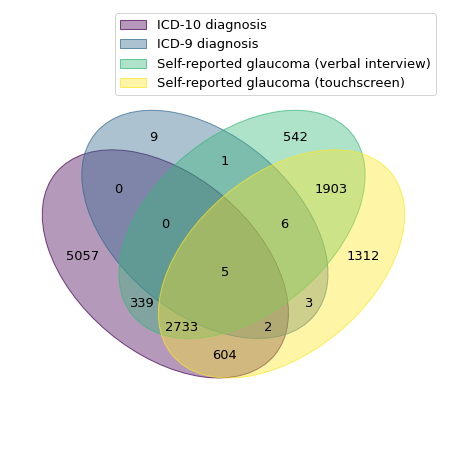

In [17]:
venn.venn({'ICD-10 diagnosis':set(df_glaucoma_data[df_glaucoma_data['ICD10 POAG'] | df_glaucoma_data['ICD10 Other glaucoma'] | df_glaucoma_data['ICD10 Glaucoma unspecified']].index),
        'ICD-9 diagnosis':set(df_glaucoma_data[df_glaucoma_data['ICD9 POAG'] | df_glaucoma_data['ICD9 Other glaucoma'] | df_glaucoma_data['ICD9 Glaucoma unspecified']].index),
           'Self-reported glaucoma (verbal interview)':set(df_glaucoma_data[df_glaucoma_data['Self-reported glaucoma 1']].index),
           'Self-reported glaucoma (touchscreen)':set(df_glaucoma_data[df_glaucoma_data['Self-reported glaucoma 2']].index)
           
          })

In [21]:
latter_glaucoma = df_glaucoma_data[df_glaucoma_data['Diagnosis Year'] > 2010]

<AxesSubplot:>

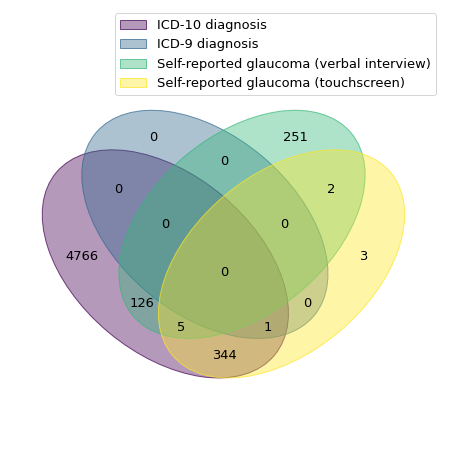

In [22]:
venn.venn({'ICD-10 diagnosis':set(latter_glaucoma[latter_glaucoma['ICD10 POAG'] | latter_glaucoma['ICD10 Other glaucoma'] | latter_glaucoma['ICD10 Glaucoma unspecified']].index),
        'ICD-9 diagnosis':set(latter_glaucoma[df_glaucoma_data['ICD9 POAG'] | latter_glaucoma['ICD9 Other glaucoma'] | latter_glaucoma['ICD9 Glaucoma unspecified']].index),
           'Self-reported glaucoma (verbal interview)':set(latter_glaucoma[latter_glaucoma['Self-reported glaucoma 1']].index),
           'Self-reported glaucoma (touchscreen)':set(latter_glaucoma[latter_glaucoma['Self-reported glaucoma 2']].index)
           
          })

In [56]:
df_glaucoma_data['Total Glaucoma'].value_counts()

False    439661
True      12516
Name: Total Glaucoma, dtype: int64

In [57]:
df_glaucoma_data['Total Glaucoma'].value_counts(normalize=True)

False    0.972321
True     0.027679
Name: Total Glaucoma, dtype: float64

# Getting earliest year of glaucoma diagnosis

Getting the earliest year of glaucoma diagnosis.
This allows us to exclude diagnoses and events that happen before the glaucoma diagnosis, minimising the possibility that reverse causation is causing an association.

Using the following columns:
- 4689 (age glaucoma diagnosed - touchscreen)
- 34 (year of birth - for year calculation)
- 20008 (year of self-reported)
- 41280 (date of diagnosis ICD10)
- 41281 (date of diagnosis ICD9)


In [58]:
year_of_diagnosis_columns = [column for column in df_fields['Field ID'] if '20008' in column or '41280' in column or '41281' in column or '4689' in column or column == 'f.34.0.0']

In [59]:
touchscreen_cols_date = [col for col in year_of_diagnosis_columns if '4689' in col]
self_reported_cols_date = [col for col in year_of_diagnosis_columns if '20008' in col]
icd10_cols_date = [col for col in year_of_diagnosis_columns if '41280' in col]
icd9_cols_date = [col for col in year_of_diagnosis_columns if '41281' in col]

In [60]:
df_date_data = get_dataframe_for_analysis(year_of_diagnosis_columns)

Preparing dataframe...


51it [12:30, 14.72s/it]                                                                               


Determine the earliest date of glaucoma diagnosis

In [61]:
earliest_date = []

for i in tqdm(range(len(df_glaucoma_data))):
    if df_glaucoma_data.iloc[i]['Total Glaucoma']:
        earliest_year_list = []

        earliest_year_list.append(df_date_data.iloc[i][touchscreen_cols_date].min() + df_date_data.iloc[i]['f.34.0.0'])

        prospective_years = pd.Series((df_glaucoma_data.iloc[i][self_reported_cols] == 1277).astype(int).values * df_date_data.iloc[i][self_reported_cols_date].values)
        earliest_year_list.append(prospective_years.apply(lambda x: np.nan if x < 1900 else x).min())

        prospective_years = pd.Series(df_glaucoma_data.iloc[i][icd10_cols].apply(lambda x: x in icd10_codes).astype(int).values * df_date_data.iloc[i][icd10_cols_date].apply(lambda x: x if pd.isna(x) else int(x.split('-')[0])).values)
        earliest_year_list.append(prospective_years.apply(lambda x: np.nan if x < 1900 else x).min())

        prospective_years = pd.Series(df_glaucoma_data.iloc[i][icd9_cols].apply(lambda x: x in icd9_codes).astype(int).values * df_date_data.iloc[i][icd9_cols_date].apply(lambda x: x if pd.isna(x) else int(x.split('-')[0])).values)
        earliest_year_list.append(prospective_years.apply(lambda x: np.nan if x < 1900 else x).min())

        earliest_year_list = [year for year in earliest_year_list if not pd.isna(year)]
        if len(earliest_year_list) > 0:
            earliest_date.append(min(earliest_year_list))
        else:
            earliest_date.append(np.nan)
    else:
        earliest_date.append(np.nan)

100%|███████████████████████████████████████████████████████| 452177/452177 [04:36<00:00, 1633.61it/s]


In [62]:
df_glaucoma_data['Diagnosis Year'] = earliest_date

<AxesSubplot:>

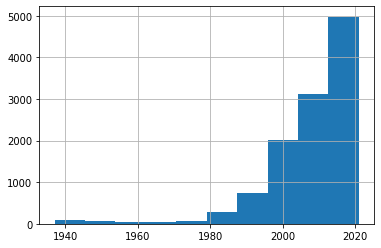

In [63]:
df_glaucoma_data['Diagnosis Year'].hist()

In [64]:
df_glaucoma_data[df_glaucoma_data['Total Glaucoma']]['Diagnosis Year'].isna().value_counts()

False    11487
True      1029
Name: Diagnosis Year, dtype: int64

In [68]:
df_glaucoma_data.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/glaucoma_data_checkpoint.pkl')

In [4]:
df_glaucoma_data = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/glaucoma_data_checkpoint.pkl')

In [69]:
df_date_data.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/date_data_checkpoint.pkl')

# Expanding columns into matrices

Certain features (e.g. ICD10 codes) span multiple columns, and would be better processed as a matrix with each column being the possible values of the feature

Does some linear algebra to multiply matrices and make everything fit together nicely

In [72]:
def get_binary_encoding_of_columns_combined_matrix(matrix_1, matrix_2):
    cols_1 = matrix_1.columns
    cols_2 = matrix_2.columns
    combined_list = pd.Series(sorted(list(set(cols_1).union(set(cols_2)))))
    encoding_1 = combined_list.apply(lambda x: 1 if x in cols_1 else 0)
    encoding_2 = combined_list.apply(lambda x: 1 if x in cols_2 else 0)
    return combined_list, encoding_1, encoding_2

In [73]:
def build_matrix_from_encodings(encoding):
    encoding_sum = encoding.sum()
    ident = np.identity(encoding_sum)
    final_matrix = []
    for item in encoding:
        if item == 1:
            final_matrix.append(ident[0])
            ident = ident[1:]
        else:
            final_matrix.append(np.zeros(encoding_sum))
    return scipy.sparse.coo_matrix(np.asarray(final_matrix).T)

In [74]:
def combine_matrices(matrix_1, matrix_2):
    if matrix_1 is None:
        return matrix_2
    combined_list, encoding_1, encoding_2 = get_binary_encoding_of_columns_combined_matrix(matrix_1, matrix_2)
    mult_matrix_1 = build_matrix_from_encodings(encoding_1)
    mult_matrix_2 = build_matrix_from_encodings(encoding_2)
    combined_matrix = matrix_1.sparse.to_coo() * mult_matrix_1 + matrix_2.sparse.to_coo() * mult_matrix_2
    df = pd.DataFrame.sparse.from_spmatrix(combined_matrix)
    df.columns = combined_list
    return df

In [75]:
def expand_matrix(df):
    current_matrix = None
    for column in tqdm(df.columns):
        matrix_to_add = pd.get_dummies(df[column],sparse=True)
        current_matrix = combine_matrices(current_matrix,matrix_to_add)
    return current_matrix

## ICD10 diagnoses

In [76]:
df_diagnoses = df_glaucoma_data[icd10_cols].copy()
df_diagnoses_dates = df_date_data[icd10_cols_date]

In [79]:
df_glaucoma_data[df_glaucoma_data['Total Glaucoma']]

,Eye problems/disorders_0,Eye problems/disorders_1,Eye problems/disorders_2,Eye problems/disorders_3,Eye problems/disorders_4,Eye problems/disorders_5,Eye problems/disorders_6,Eye problems/disorders_7,Eye problems/disorders_8,Eye problems/disorders_9,...,ICD10 POAG,ICD10 Other glaucoma,ICD10 Glaucoma unspecified,ICD9 POAG,ICD9 Other glaucoma,ICD9 Glaucoma unspecified,Self-reported glaucoma 1,Self-reported glaucoma 2,Total Glaucoma,Diagnosis Year
28,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,True,2015.0
81,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,False,False,False,True,2013.0
172,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,True,True,True,1990.5
189,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,True,True,True,1993.5
191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,False,False,False,False,True,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,True,False,False,False,False,False,True,2015.0
452054,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,True,True,True,2001.5
452072,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,True,2016.0
452119,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,True,True,True,2008.0


Want to exclude diagnoses that happened after 2010

In [99]:
for i in tqdm(range(len(df_glaucoma_data))):
    patient_all_dx = []
    for icd_code, diagnosis_year in zip(df_diagnoses.iloc[i], df_diagnoses_dates.iloc[i].apply(lambda x: np.nan if pd.isna(x) else int(x.split('-')[0]))):
        if diagnosis_year <= 2010:
            patient_all_dx.append(icd_code)
        else:
            patient_all_dx.append(np.nan)
    df_diagnoses.iloc[i] = patient_all_dx

100%|███████████████████████████████████████████████████████| 452177/452177 [06:07<00:00, 1229.24it/s]


Saving a checkpoint!

In [103]:
df_diagnoses.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/icd10_checkpoint_1.pkl')

In [104]:
df_diagnoses = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/icd10_checkpoint_1.pkl')

In [105]:
df_diagnoses.dropna(axis='columns', how='all', inplace=True)

In [107]:
icd_10_matrix = expand_matrix(df_diagnoses)

100%|███████████████████████████████████████████████████████████████| 213/213 [19:53<00:00,  5.60s/it]


In [110]:
icd_10_matrix.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/icd10_checkpoint_2.pkl')

In [26]:
icd_10_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/icd10_checkpoint_2.pkl')

## Self-reported diagnoses

In [115]:
df_self_reported = df_glaucoma_data[self_reported_cols].copy()
df_self_reported_dates = df_date_data[self_reported_cols_date]

Want to exclude diagnoses that happened after 2010

In [116]:
for i in tqdm(range(len(df_glaucoma_data))):
    patient_all_dx = []
    for code, diagnosis_year in zip(df_self_reported.iloc[i], df_self_reported_dates.iloc[i]):
        if diagnosis_year <= 2010:
            patient_all_dx.append(code)
        else:
            patient_all_dx.append(np.nan)
    df_self_reported.iloc[i] = patient_all_dx

100%|███████████████████████████████████████████████████████| 452177/452177 [01:33<00:00, 4827.97it/s]


In [117]:
df_self_reported.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/self_reported_diagnosis_checkpoint_1.pkl')

In [118]:
df_self_reported = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/self_reported_diagnosis_checkpoint_1.pkl')

In [124]:
df_self_reported.dropna(axis='columns', how='all', inplace=True)

In [125]:
self_reported_matrix = expand_matrix(df_self_reported)

100%|█████████████████████████████████████████████████████████████████| 97/97 [00:16<00:00,  5.97it/s]


Matrix is of the number of appearances - flatten it into a binary matrix

In [128]:
self_reported_matrix = np.ceil(self_reported_matrix / 4)

In [129]:
self_reported_matrix.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/self_reported_diagnosis_checkpoint_2.pkl')

In [28]:
self_reported_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/self_reported_diagnosis_checkpoint_2.pkl')

## Cancer diagnoses

In [131]:
cancer_codes = [column for column in df_fields['Field ID'] if '20001' in column]
cancer_codes_date = [column for column in df_fields['Field ID'] if '20006' in column]

In [132]:
df_cancer_data = get_dataframe_for_analysis(cancer_codes)

Preparing dataframe...


51it [08:28,  9.98s/it]                                                                               


In [133]:
df_cancer_data_dates = get_dataframe_for_analysis(cancer_codes_date)

Preparing dataframe...


51it [08:40, 10.21s/it]                                                                               


Excluding diagnoses that happened after 2010

In [67]:
for i in tqdm(range(len(df_glaucoma_data))):
    patient_all_dx = []
    for code, diagnosis_year in zip(df_cancer_data.iloc[i], df_cancer_data_dates.iloc[i]):
        if not diagnosis_year >= 2010:
            patient_all_dx.append(code)
        else:
            patient_all_dx.append(np.nan)
    df_cancer_data.iloc[i] = patient_all_dx

100%|███████████████████████████████████████████████████████| 452177/452177 [03:43<00:00, 2027.20it/s]


In [137]:
df_cancer_data.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/cancer_diagnosis_checkpoint_1.pkl')

In [138]:
df_cancer_data = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/cancer_diagnosis_checkpoint_1.pkl')

In [139]:
df_cancer_data.dropna(axis='columns', how='all', inplace=True)

In [140]:
cancer_matrix = expand_matrix(df_cancer_data)

100%|█████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 38.54it/s]


In [141]:
cancer_matrix = np.ceil(cancer_matrix / 4)

In [142]:
cancer_matrix.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/cancer_diagnosis_checkpoint_2.pkl')

In [30]:
cancer_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/cancer_diagnosis_checkpoint_2.pkl')

## Medications

Just get codes from initial assessment visit from 2006-2010

In [148]:
med_codes = [column for column in df_fields['Field ID'] if '20003.0' in column]

In [150]:
df_med_data = get_dataframe_for_analysis(med_codes)

Preparing dataframe...


51it [07:07,  8.38s/it]                                                                               


In [155]:
df_med_data.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/meds_checkpoint_1.pkl')

In [156]:
df_med_data = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/meds_checkpoint_1.pkl')

In [157]:
med_matrix = expand_matrix(df_med_data)

100%|█████████████████████████████████████████████████████████████████| 48/48 [00:46<00:00,  1.04it/s]


In [163]:
med_matrix = np.ceil(med_matrix / len(med_codes))

In [166]:
med_matrix.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/meds_checkpoint_2.pkl')

In [32]:
med_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/meds_checkpoint_2.pkl')

# Cleaning columns

In [121]:
df_all_clinical_columns = get_dataframe_for_analysis(df_selected_fields['Field ID'].values)

Preparing dataframe...


51it [23:33, 27.72s/it]                                                                                                       
51it [00:56,  1.10s/it]                                                        


In [125]:
df_all_clinical_columns = df_all_clinical_columns[df_all_clinical_columns.columns[1:]]

In [129]:
df_all_clinical_columns.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/all_clinical_columns_raw.pkl')

In [27]:
df_all_clinical_columns = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/all_clinical_columns_raw.pkl')

In [15]:
def clean_numeric_column(column):
    # Don't process things that aren't actually columns
    if type(column) == pd.core.frame.DataFrame:
        return clean_numeric_column(column.iloc[:,0])
    # ensure all values are numeric -- or as many as possible
    try:
        col_numeric = column.astype(np.float32)
    except:
        col_replaced_numeric = []
        for item in column:
            try:
                col_replaced_numeric.append(np.float32(item))
            except:
                col_replaced_numeric.append(np.nan)
        col_numeric = pd.Series(col_replaced_numeric)
    # deal with negative values
    unique_negative_values = len(pd.Series([item for item in col_numeric if item < 0]).value_counts().keys())
    col_cleaned = []
    if unique_negative_values <= 5: # if there five or fewer unique negative values, remove them. This recognises cases where negative values are special markers
        for value in col_numeric:
            if value >= 0:
                col_cleaned.append(value)
            else:
                col_cleaned.append(np.nan)
        output = pd.Series(col_cleaned)
    else:
        output = col_numeric
    output.name = column.name
    #output.fillna(value=output.mean(),inplace=True)
    return output

In [16]:
def clean_categorical_column(column, dummies=True):
    if dummies:
        return clean_categorical_column_with_dummies(column)
    else:
        return clean_categorical_column_no_dummies(column)

In [17]:
def clean_categorical_column_no_dummies(column):
    # Don't process things that aren't actually columns
    if type(column) == pd.core.frame.DataFrame:
        return pd.DataFrame()
    # replace all negative values with np.nan
    no_neg_list = []
    for item in column:
        try:
            if np.float64(item) < 0:
                no_neg_list.append(np.nan)
            else:
                no_neg_list.append(item)
        except:
            no_neg_list.append(item)
    output = pd.Series(no_neg_list)
    # return empty dataframe if no values remain
    if len(output.value_counts().keys()) == 0:
        return pd.DataFrame()
    output.name = column.name
    #output.fillna(value=output.mode().values[0],inplace=True)
    return output

In [18]:
def clean_categorical_column_with_dummies(column):
    # Don't process things that aren't actually columns
    if type(column) == pd.core.frame.DataFrame:
        return pd.DataFrame()
    no_neg_list = []
    for item in column:
        try:
            if np.float64(item) < 0:
                no_neg_list.append(np.nan)
            else:
                no_neg_list.append(item)
        except:
            no_neg_list.append(item)
    new_series = pd.Series(no_neg_list)
    if len(new_series.value_counts().keys()) == 0:
        return pd.DataFrame()
    base_class = new_series.value_counts().keys()[0]
    dummies = pd.get_dummies(new_series,prefix=column.name)#+'_'+str(base_class),dummy_na=True)
    #dummies.drop(column.name+'_'+str(base_class)+'_'+str(base_class), axis=1, inplace=True)
    return dummies

In [19]:
numeric_columns = [col for col in df_all_clinical_columns.columns if id_to_type[col] == 'Continuous' or id_to_type[col] == 'Integer']
categorical_columns = [col for col in df_all_clinical_columns.columns if 'Categorical' in id_to_type[col]]

In [20]:
processed_numeric_columns = [clean_numeric_column(df_all_clinical_columns[col]) for col in tqdm(numeric_columns)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [02:33<00:00,  6.00it/s]


In [21]:
processed_categorical_columns = [clean_categorical_column(df_all_clinical_columns[col]) for col in tqdm(categorical_columns)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1084/1084 [04:50<00:00,  3.73it/s]


In [22]:
# remove columns that only have NaN
processed_categorical_columns = [col for col in processed_categorical_columns if len(col) != 0]

In [23]:
all_processed_columns = processed_numeric_columns + processed_categorical_columns
df_processed = pd.concat(all_processed_columns, axis=1)

In [24]:
# remove remaining non-numeric columns
cols_to_retain = []
for col in df_processed.columns:
    if df_processed.dtypes[col] == np.float64 or df_processed.dtypes[col] == np.float32  or df_processed.dtypes[col] == np.uint8:
        cols_to_retain.append(col)
df_processed = df_processed[cols_to_retain].copy()

In [26]:
df_processed.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/processed_data_checkpoint_with_dummies.pkl')

In [27]:
df_processed = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/processed_data_checkpoint_with_dummies.pkl')

Convert to sparse...

In [28]:
colnames = df_processed.columns

In [29]:
df_processed = pd.DataFrame.sparse.from_spmatrix(scipy.sparse.coo_matrix(df_processed))
df_processed.columns = colnames

In [30]:
df_processed.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/processed_data_checkpoint_2_with_dummies.pkl')

In [34]:
df_processed = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/processed_data_checkpoint_2_with_dummies.pkl')

# Merge matrices

In [ ]:
df_processed = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/processed_data_checkpoint_2_with_dummies.pkl')
df_glaucoma_data = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/glaucoma_data_checkpoint.pkl')
df_date_data = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/date_data_checkpoint.pkl')
med_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/meds_checkpoint_2.pkl')
cancer_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/cancer_diagnosis_checkpoint_2.pkl')
self_reported_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/self_reported_diagnosis_checkpoint_2.pkl')
icd_10_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/icd10_checkpoint_2.pkl')
df_all_clinical_columns = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/all_clinical_columns_raw.pkl')
df_diagnoses = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/icd10_checkpoint_1.pkl')

Prefix the column names of the matrices

In [57]:
matrix_names = ['ICD_10_', 'Self_Report_', 'Cancer_', 'Med_']
matrices = [icd_10_matrix, self_reported_matrix, cancer_matrix, med_matrix]

for matrix_name, matrix in zip(matrix_names, matrices):
    new_col_names = []
    for col in matrix.columns:
        new_col_names.append(matrix_name+str(col))
    matrix.columns = new_col_names

Remove columns with less than 30 positive results

In [58]:
for i in range(len(matrix_names)):
    cols_to_keep = []
    for col in matrices[i].columns:
        if matrices[i][col].value_counts()[1.0] > 30:
            cols_to_keep.append(col)
    matrices[i] = matrices[i][cols_to_keep]

Combine matrices

In [59]:
combined_sparse_matrix = pd.concat(matrices,axis=1)
combined_matrix = pd.concat([df_processed,combined_sparse_matrix],axis=1)

## Remove predictors significantly correlated with endpoints

Glacuoma-related columns:

In [60]:
icd_glaucoma_columns = [col for col in combined_sparse_matrix.columns if 'ICD_10_H40' in col]
self_reported_glaucoma_column = ['Self_Report_1277.0']
eye_problem_columns = [column for column in combined_matrix.columns if 'f.6148.0.0' in column] + [column for column in combined_matrix.columns if 'f.2227.0.0' in column]

IOP-related columns:

In [61]:
iop_columns = ['f.5263.0.0','f.5262.0.0','f.5254.0.0','f.5255.0.0']

In [62]:
columns_to_remove = icd_glaucoma_columns + self_reported_glaucoma_column + eye_problem_columns + iop_columns

In [63]:
combined_matrix.drop(columns_to_remove,axis=1,inplace=True)

# Filtering the training population

Keep participants who:
- have no glacouma diagnosis
- have a glaucoma diagnosis only if the diagnosis is dated after 2010
- (and keep only participants who have at least one hospital ICD10 code)

In [76]:
icd_10_date_cols = [col for col in df_date_data.columns if '41280' in col]
df_date_data = df_date_data[icd_10_date_cols]

In [88]:
df_any_diagnosis_before_2010 = pd.DataFrame()

In [89]:
for col in df_date_data.columns:
    df_any_diagnosis_before_2010[col] = df_date_data[col].apply(lambda x: int(str(x)[:4]) <= 2010 if not pd.isna(x) else False)

In [94]:
any_diag_before_2010 = []
for i in tqdm(range(len(df_any_diagnosis_before_2010))):
    any_diag_before_2010.append(True in df_any_diagnosis_before_2010.iloc[i].values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 452177/452177 [03:38<00:00, 2066.20it/s]


In [111]:
filter_series = (~df_glaucoma_data['Total Glaucoma'] | (df_glaucoma_data['Diagnosis Year'] > 2010)) & (pd.Series(any_diag_before_2010))

In [112]:
filtered_matrix = combined_matrix[filter_series].copy()
filtered_matrix.reset_index(drop=True,inplace=True)

Endpoint 1: glaucoma diagnosis

In [113]:
glaucoma_diagnosis = df_glaucoma_data[filter_series]['Total Glaucoma'].copy()
glaucoma_diagnosis.reset_index(drop=True,inplace=True)
glaucoma_diagnosis = glaucoma_diagnosis.apply(lambda x: 1 if x else 0)

Endpoint 2: IOP

In [114]:
df_iop = df_all_clinical_columns[['f.5262.0.0','f.5264.0.0']]
df_iop_filtered = df_iop[filter_series].copy()
df_iop_filtered.reset_index(drop=True,inplace=True)

In [115]:
filtered_matrix.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/filtered_matrix_checkpoint_with_dummies.pkl')

In [116]:
glaucoma_diagnosis.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/glaucoma_diagnosis_checkpoint.pkl')

In [117]:
df_iop_filtered.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/iop_checkpoint.pkl')

# Mann-Whitney u filtering

In [3]:
filtered_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/filtered_matrix_checkpoint_with_dummies.pkl')

In [8]:
glaucoma_diagnosis = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/glaucoma_diagnosis_checkpoint.pkl')

In [9]:
glaucoma_diagnosis.value_counts()

0    296418
1      4255
Name: Total Glaucoma, dtype: int64

In [95]:
glaucoma_matrix = filtered_matrix[glaucoma_diagnosis == 1]
non_glaucoma_matrix = filtered_matrix[glaucoma_diagnosis == 0]

In [17]:
mann_whitney_fields = [field for field in filtered_matrix.columns if field in df_fields['Field ID'].values]
chi_square_fields = [field for field in filtered_matrix.columns if not field in df_fields['Field ID'].values]

In [18]:
def get_value(col, matrix, index):
    if index in matrix[col].value_counts().keys():
        value = matrix[col].value_counts()[index]
    else:
        value = 0
    return value

In [19]:
p_values = []
for col in tqdm(filtered_matrix.columns):
    if col in mann_whitney_fields:
        glauc = glaucoma_matrix[col].dropna().values
        non_glauc = non_glaucoma_matrix[col].dropna().values
        if len(glauc) == 0 or len(non_glauc) == 0:
            p_values.append(np.nan)
        else:
            p_values.append(scipy.stats.mannwhitneyu(glauc, non_glauc)[1])
    else:
        try:
            p_value = scipy.stats.chi2_contingency([[get_value(col, glaucoma_matrix, 0), get_value(col, glaucoma_matrix, 1)],[get_value(col, non_glaucoma_matrix, 0), get_value(col, non_glaucoma_matrix, 1)]])[1]
            p_values.append(p_value)
        except:
            p_values.append(np.nan)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10071/10071 [01:48<00:00, 93.18it/s]


In [22]:
significant_results = statsmodels.stats.multitest.multipletests(p_values, alpha=0.2, method='fdr_by')[0]

In [23]:
cols_to_keep = filtered_matrix.columns[significant_results]

In [24]:
filtered_matrix_significant_columns = filtered_matrix[cols_to_keep].copy()

In [26]:
filtered_matrix_significant_columns.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/filtered_matrix_pre_imputation_checkpoint.pkl')

# Imputation

In [5]:
filtered_matrix_significant_columns = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/filtered_matrix_pre_imputation_checkpoint.pkl')

Simple Imputer

In [28]:
from sklearn.impute import SimpleImputer

In [29]:
smp_imputer = SimpleImputer(strategy='mean',verbose=2)

In [30]:
t0 = time.time()
smp_imputer.fit(filtered_matrix_significant_columns)
print(time.time() - t0)

5.713629484176636


In [31]:
t0 = time.time()
imputed_significant_columns = pd.DataFrame.sparse.from_spmatrix(smp_imputer.transform(filtered_matrix_significant_columns), columns=filtered_matrix_significant_columns.columns)
print(time.time() - t0)

6.082390308380127


In [32]:
imputed_significant_columns.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/filtered_matrix_post_imputation_checkpoint.pkl')

# Random forests model for glaucoma

## Age only model

In [202]:
age_clf = RandomForestClassifier(class_weight='balanced',max_depth=10, random_state=42)

In [203]:
X_train = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/train_set_all_columns.pkl')
X_val = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/val_set_all_columns.pkl')

In [204]:
t0 = time.time()
age_clf.fit(X_train[['f.34.0.0']],y_train)
print(time.time() - t0)

16.687697649002075


In [206]:
y_train_pred_proba = age_clf.predict_proba(X_train[['f.34.0.0']])

In [207]:
accuracy_score(y_train,(y_train_pred_proba[:,1] > 0.9).astype(int))

0.9857282755307551

In [208]:
roc_auc_score(y_train,y_train_pred_proba[:,1])

0.6767978904386627

In [209]:
y_val_pred_proba = age_clf.predict_proba(X_val[['f.34.0.0']])

In [210]:
accuracy_score(y_val,(y_val_pred_proba[:,1] > 0.9).astype(int))

0.9869296261806572

In [211]:
roc_auc_score(y_val,y_val_pred_proba[:,1])

0.6925902536168972

## Initial model

In [14]:
imputed_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/filtered_matrix_post_imputation_checkpoint.pkl')

In [106]:
int_train_idx, int_val_idx = train_test_split(range(len(imputed_matrix)),random_state=TEST_SET_RANDOM_SPLIT, test_size=0.1)

In [16]:
X_train = imputed_matrix.iloc[int_train_idx].copy().reset_index(drop=True)
X_val = imputed_matrix.iloc[int_val_idx].copy().reset_index(drop=True)

In [17]:
X_train.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/train_set_all_columns.pkl')
X_val.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/val_set_all_columns.pkl')

In [53]:
X_train = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/train_set_all_columns.pkl')
X_val = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/val_set_all_columns.pkl')

In [19]:
glaucoma_diagnosis = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/glaucoma_diagnosis_checkpoint.pkl')

In [20]:
y_train = glaucoma_diagnosis.iloc[int_train_idx].copy().reset_index(drop=True)
y_val = glaucoma_diagnosis.iloc[int_val_idx].copy().reset_index(drop=True)

In [21]:
forest_clf = RandomForestClassifier(class_weight='balanced',max_depth=10, random_state=42)

In [22]:
t0 = time.time()
forest_clf.fit(X_train,y_train)
print(time.time() - t0)

254.37706351280212


## Validate model

Train set

In [23]:
y_train_pred_proba = forest_clf.predict_proba(X_train)

In [24]:
accuracy_score(y_train,(y_train_pred_proba[:,1] > 0.9).astype(int))

0.9857282755307551

In [25]:
roc_auc_score(y_train,y_train_pred_proba[:,1])

0.8414426112886657

Val set

In [26]:
y_val_pred_proba = forest_clf.predict_proba(X_val)

In [27]:
accuracy_score(y_val,(y_val_pred_proba[:,1] > 0.9).astype(int))

0.9869296261806572

In [28]:
roc_auc_score(y_val,y_val_pred_proba[:,1])

0.7268452338844694

In [46]:
dump(forest_clf,'../glaucoma_project/Models/forest_clf_1.joblib')

['../glaucoma_project/Models/forest_clf_1.joblib']

In [47]:
forest_clf = load('../glaucoma_project/Models/forest_clf_1.joblib')

## Ranking by feature importances

In [29]:
df_feature_importances = pd.DataFrame()
df_feature_importances['Feature ID'] = X_train.columns
df_feature_importances['RF importance'] = forest_clf.feature_importances_

In [30]:
df_feature_importances["Feature Name"] = df_feature_importances["Feature ID"].apply(feature_id_to_name)

In [34]:
df_feature_importances.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/feature_importances_rf.pkl')

## 10% subsets

In [116]:
imputed_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/filtered_matrix_post_imputation_checkpoint.pkl')

In [36]:
glaucoma_diagnosis = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/glaucoma_diagnosis_checkpoint.pkl')

In [37]:
NUM_ITER = 50

In [38]:
np.random.seed(42)
sample_seeds = [np.random.randint(1,2**32 - 1) for i in range(NUM_ITER)]
forest_seeds = [np.random.randint(1,2**32 - 1) for i in range(NUM_ITER)]

In [39]:
def get_feature_importances_from_subset(sample_seed, forest_seed):
    subset_idx, _ = train_test_split(range(len(imputed_matrix)),random_state=sample_seed, train_size=0.1)
    X_train = imputed_matrix.iloc[subset_idx].copy().reset_index(drop=True)
    y_train = glaucoma_diagnosis.iloc[subset_idx].copy().reset_index(drop=True)
    forest_clf = RandomForestClassifier(class_weight='balanced',max_depth=10, random_state=forest_seed)
    forest_clf.fit(X_train,y_train)
    df_feature_importances_subset = pd.DataFrame()
    return forest_clf.feature_importances_

In [40]:
df_feature_importances_subsets = pd.DataFrame(columns=imputed_matrix.columns)
for sample_seed, forest_seed in tqdm(zip(sample_seeds, forest_seeds), total=NUM_ITER):
    imps = get_feature_importances_from_subset(sample_seed, forest_seed)
    importances_dict = {label:imp for label, imp in zip(imputed_matrix.columns, imps)}
    df_feature_importances_subsets = df_feature_importances_subsets.append(importances_dict, ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [20:03<00:00, 24.07s/it]


In [41]:
mins = []
means = []
maxes = []
sd = []
for col in df_feature_importances_subsets:
    means.append(df_feature_importances_subsets[col].mean())
    mins.append(df_feature_importances_subsets[col].min())
    maxes.append(df_feature_importances_subsets[col].max())
    sd.append(df_feature_importances_subsets[col].std())
df_feature_importance_stats = pd.DataFrame()
df_feature_importance_stats['Feature ID'] = df_feature_importances_subsets.columns
df_feature_importance_stats['Feature Names'] = df_feature_importance_stats["Feature ID"].apply(feature_id_to_name)
df_feature_importance_stats['Mean'] = means
df_feature_importance_stats['SD'] = sd
df_feature_importance_stats['Min'] = mins
df_feature_importance_stats['Max'] = maxes

In [43]:
df_feature_importances_subsets.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/feature_importances_subsets.pkl')

In [44]:
df_feature_importance_stats.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/feature_importances_stats.pkl')

In [7]:
df_feature_importance_stats = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/feature_importances_stats.pkl')

In [52]:
feat_order = df_feature_importance_stats.sort_values('Min', ascending=False)['Feature ID']

In [55]:
X_train_ordered = X_train[feat_order]

In [56]:
name_to_id_full_dict = {feature_id_to_name(id_):id_ for id_ in X_train_ordered.columns}

## Correlated features - VIF

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [192]:
t0 = time.time()
print(variance_inflation_factor(X_train_ordered[['f.34.0.0',name_to_id_full_dict['Systolic blood pressure, automated reading_0']]],1))
print(time.time() - t0)

53.988793845279744
0.014888525009155273


In [55]:
df_matrix = pd.DataFrame()

In [56]:
def variance_inflation_factor_matrix(df_train):
    df_matrix = pd.DataFrame()
    for col_1 in tqdm(df_train.columns):
        new_col = []
        for col_2 in df_train.columns:
            new_col.append(variance_inflation_factor(df_train[[col_1,col_2]],1))
        df_matrix[col_1] = new_col
    return df_matrix

In [57]:
def vif_matrix_to_collinear_groups(vif_matrix, vif_cutoff = 5):
    columns_added_to_dict = []
    collinearity_dict = {}
    for col_1 in vif_matrix:
        if not col_1 in columns_added_to_dict:
            
            collinearity_dict[col_1] = []
            columns_added_to_dict.append(col_1)
            
            current_vifs = {col_name:vif for col_name, vif in zip(vif_matrix.columns, vif_matrix[col_1])}
            
            for col_2 in current_vifs.keys():
                if not col_2 in columns_added_to_dict:
                    if current_vifs[col_2] > vif_cutoff:
                        collinearity_dict[col_1].append(col_2)
                        columns_added_to_dict.append(col_2)
    return collinearity_dict

In [58]:
hundred_matrix = variance_inflation_factor_matrix(X_train_ordered[X_train_ordered.columns[:500]])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:03:46<00:00,  7.65s/it]


In [59]:
hundred_matrix.columns = [feature_id_to_name(id_) for id_ in hundred_matrix.columns]
hundred_matrix['Col'] = [feature_id_to_name(id_) for id_ in hundred_matrix.columns]

In [60]:
hundred_matrix.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/vif_matrix.pkl')

In [61]:
hundred_matrix.to_csv('vif_matrix.csv')

In [68]:
collinearity_dict = vif_matrix_to_collinear_groups(hundred_matrix, 10)

In [69]:
df_collinearity = pd.DataFrame()
df_collinearity['Lead Fields'] = collinearity_dict.keys()
df_collinearity['Collinear Fields'] = collinearity_dict.values()
df_collinearity.to_csv('vif_10_collinearity_dict.csv')

In [70]:
df_collinearity['Field ID'] = df_collinearity['Lead Fields'].apply(lambda x: name_to_id_full_dict[x] if x in name_to_id_full_dict.keys() else None)

In [97]:
#def remove_highly_collinear_features(feature_importance_order, df_train, vif_cutoff=5):
#    chosen_feature_list = [feature_importance_order[0]]
#    for feature_id in tqdm(feature_importance_order):
#        if not feature_id in chosen_feature_list:
#            current_subset = df_train[chosen_feature_list + [feature_id]]
#            vif = variance_inflation_factor(current_subset, len(current_subset.columns)-1)
#            if vif < vif_cutoff:
#                chosen_feature_list.append(feature_id)
#    return chosen_feature_list

In [101]:
#chosen_features = remove_highly_collinear_features(X_train_top_thousand.columns, X_train_top_thousand)

100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [4:38:44<00:00, 16.72s/it]


In [5]:
#chosen_features = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/442_features.pkl')

In [31]:
#df_feature_importances[df_feature_importances['Feature ID'].isin(chosen_features)].sort_values('RF importance',ascending=False).to_csv('442_features_table.csv')

## Correlated Features - Logit

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

Experiment - get the unimputed data

In [105]:
unimputed_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/filtered_matrix_pre_imputation_checkpoint.pkl')

In [107]:
X_train_unimputed = unimputed_matrix.iloc[int_train_idx].copy().reset_index(drop=True)

In [180]:
#small_idx, _ = train_test_split(range(len(X_train_unimputed)),random_state=0, train_size=0.1)
std_scaler = StandardScaler()
df_scaled = pd.DataFrame(std_scaler.fit_transform(X_train_unimputed.sparse.to_dense()),columns=X_train_unimputed.columns)
df_scaled['Total Glaucoma'] = y_train
def determine_rsquared_improvement(init_var,var_to_add):
    current_df = df_scaled[[init_var,var_to_add,'Total Glaucoma']].dropna()
    if len(current_df) == 0:
        return 1
    log_reg_init = Logit(current_df['Total Glaucoma'], add_constant(current_df[init_var],prepend=False))
    try:
        res = log_reg_init.fit(disp=False)
    except Exception:
        return 1
    init_llf = res.llf
    
    log_reg_second = Logit(current_df['Total Glaucoma'], add_constant(current_df[[init_var,var_to_add]],prepend=False))
    try:
        res = log_reg_second.fit(disp=False)
    except Exception:
        return 1
    second_llf = res.llf
    
    LR_statistic = -2*(init_llf - second_llf)
    p_val = scipy.stats.chi2.sf(LR_statistic, 2)

    return p_val

In [191]:
t0 = time.time()
print(determine_rsquared_improvement('f.34.0.0',name_to_id_full_dict['Systolic blood pressure, automated reading_0']))
print(time.time() - t0)

0.7375049899781189
0.340806245803833


In [339]:
df_matrix = pd.DataFrame()

In [340]:
def logit_matrix(df_train):
    df_matrix = pd.DataFrame()
    for col_1 in tqdm(df_train.columns):
        new_col = []
        for col_2 in df_train.columns:
            try:
                new_col.append(determine_rsquared_improvement(col_1, col_2))
            except Exception:
                new_col.append(np.nan)
        df_matrix[col_1] = new_col
    return df_matrix

In [356]:
logit_matrix_output = logit_matrix(X_train_ordered[X_train_ordered.columns[:200]])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [29:54<00:00,  8.97s/it]


In [357]:
logit_matrix_output.columns = [feature_id_to_name(id_) for id_ in logit_matrix_output.columns]
logit_matrix_output['Col'] = [id_ for id_ in logit_matrix_output.columns]

In [358]:
def logit_matrix_to_collinear_groups(logit_matrix, cutoff = 0.005):
    columns_added_to_dict = []
    collinearity_dict = {}
    for col_1 in logit_matrix:
        if not col_1 in columns_added_to_dict:
            
            collinearity_dict[col_1] = []
            columns_added_to_dict.append(col_1)
            
            current_diffs = {col_name:diff for col_name, diff in zip(logit_matrix.columns, logit_matrix[col_1])}
            
            for col_2 in current_diffs.keys():
                if not col_2 in columns_added_to_dict:
                    if current_diffs[col_2] < cutoff:
                        collinearity_dict[col_1].append(col_2)
                        columns_added_to_dict.append(col_2)
    return collinearity_dict

In [363]:
corr_dict = logit_matrix_to_collinear_groups(logit_matrix_output,0.001)

In [364]:
df_corr = pd.DataFrame()
df_corr['Lead Fields'] = corr_dict.keys()
df_corr['Fields With Limited Value'] = corr_dict.values()
df_corr.to_csv('log_reg_collinearity_dict.csv')

In [188]:
def vif_matrix_to_collinear_groups_with_log_reg_check(vif_matrix, vif_cutoff = 5, pr_cutoff=0.05):
    columns_added_to_dict = []
    collinearity_dict = {}
    for col_1 in tqdm(vif_matrix):
        if not col_1 in columns_added_to_dict:
            
            collinearity_dict[col_1] = []
            columns_added_to_dict.append(col_1)
            
            current_vifs = {col_name:vif for col_name, vif in zip(vif_matrix.columns, vif_matrix[col_1])}
            
            for col_2 in current_vifs.keys():
                if not col_2 in columns_added_to_dict:
                    if current_vifs[col_2] > vif_cutoff:
                        if determine_rsquared_improvement(name_to_id_full_dict[col_1], name_to_id_full_dict[col_2]) > pr_cutoff:
                            collinearity_dict[col_1].append(col_2)
                            columns_added_to_dict.append(col_2)
    return collinearity_dict

In [189]:
improved_collinearity_dict = vif_matrix_to_collinear_groups_with_log_reg_check(hundred_matrix, 10, 0.05)

501it [01:38,  5.06it/s]                                                                                                                                                                                      


In [190]:
df_collinearity_improved = pd.DataFrame()
df_collinearity_improved['Lead Fields'] = improved_collinearity_dict.keys()
df_collinearity_improved['Collinear Fields'] = improved_collinearity_dict.values()
df_collinearity_improved.to_csv('vif_10_0.05_collinearity_dict.csv')

## Taking only non-correlated features

In [237]:
X_train_non_correlated = X_train[df_collinearity['Field ID'].values[:-1]]
X_val_non_correlated = X_val[df_collinearity['Field ID'].values[:-1]]

In [238]:
forest_clf_3 = RandomForestClassifier(class_weight='balanced',max_depth=10, random_state=42)

In [239]:
t0 = time.time()
forest_clf_3.fit(X_train_non_correlated,y_train)
print(time.time() - t0)

268.4484393596649


In [ ]:
forest_clf_3 = load('../glaucoma_project/Models/forest_clf_3.joblib')

## Validate new model

Train

In [240]:
y_train_pred_proba = forest_clf_3.predict_proba(X_train_non_correlated)

In [241]:
accuracy_score(y_train,(y_train_pred_proba[:,1] > 0.5).astype(int))

0.6956192919881291

In [242]:
roc_auc_score(y_train,y_train_pred_proba[:,1])

0.8366392241787824

Val

In [243]:
y_val_pred_proba = forest_clf_3.predict_proba(X_val_non_correlated)

In [244]:
accuracy_score(y_val,(y_val_pred_proba[:,1] > 0.5).astype(int))

0.6900440291131279

In [245]:
roc_auc_score(y_val,y_val_pred_proba[:,1])

0.7425545491544384

# Random forests model for IOP

In [10]:
forest_reg = RandomForestRegressor(n_jobs=-1)

In [4]:
filtered_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/filtered_matrix_checkpoint.pkl')
df_iop_filtered = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/iop_checkpoint.pkl')

In [5]:
highest_iop = [max(left, right) for left, right in zip(df_iop_filtered['f.5262.0.0'], df_iop_filtered['f.5264.0.0'])]
df_iop_filtered['Worst IOP'] = highest_iop

In [6]:
iop_filtered_matrix = filtered_matrix[~df_iop_filtered['Worst IOP'].isna()].reset_index(drop=True)

In [7]:
df_iop_filtered = df_iop_filtered[~df_iop_filtered['Worst IOP'].isna()].reset_index(drop=True)

In [8]:
iop_filtered_matrix.dropna(axis=1, inplace=True)

In [11]:
#t0 = time.time()
#forest_reg.fit(iop_filtered_matrix,df_iop_filtered['Worst IOP'])
#print(time.time() - t0)

20428.30959033966


In [17]:
forest_reg = load('../glaucoma_project/Models/forest_reg_clinical_features_iop.joblib')

In [40]:
df_feature_importances = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/feature_importances_table_rf.pkl')
df_feature_importances['IOP RF Importance'] = forest_reg_2.feature_importances_
df_feature_importances.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/feature_importances_table_rf.pkl')

# Feature importances

In [3]:
df_feature_importances = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/feature_importances_table_rf.pkl')

<AxesSubplot:xlabel='Importance for glaucoma prediction', ylabel='Importance for IOP prediction'>

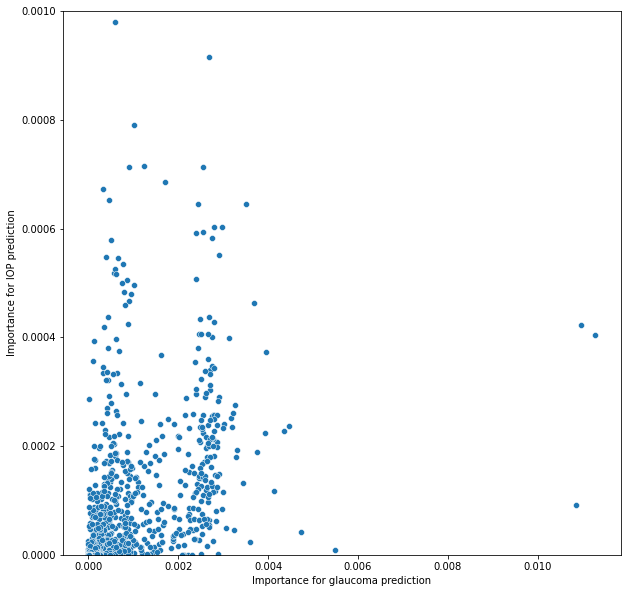

In [16]:
plt.figure(figsize=(10,10))
plt.ylim(0,0.001)
plt.xlabel('Importance for glaucoma prediction')
plt.ylabel('Importance for IOP prediction')
sns.scatterplot(df_feature_importances['RF importance'], df_feature_importances['IOP RF Importance'])

<BarContainer object of 50 artists>

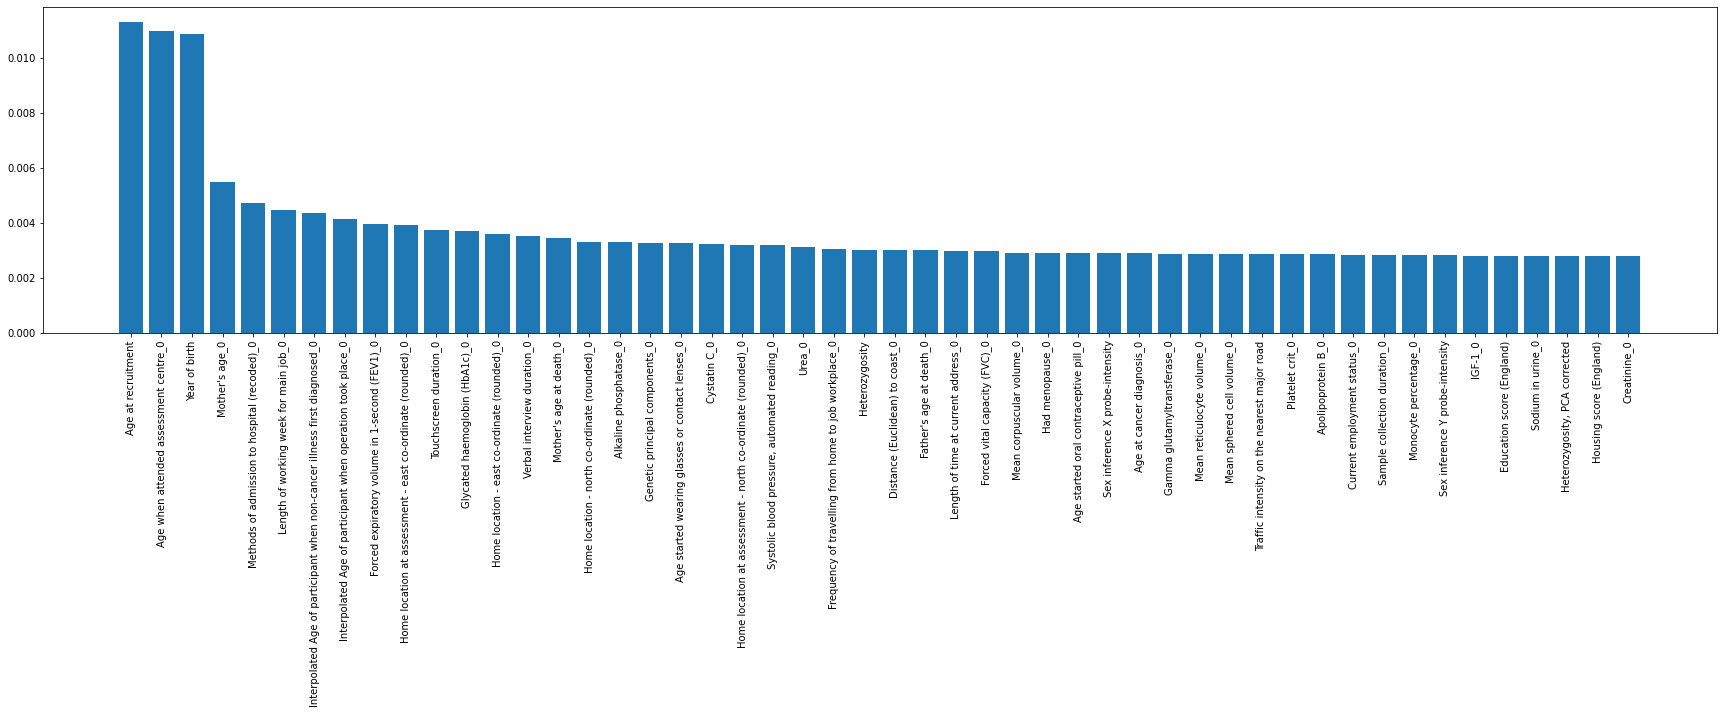

In [5]:
plt.figure(figsize=(30,6))
plt.xticks(rotation=90)

num_feats = 50
plt.bar(df_feature_importances.sort_values('RF importance', ascending=False)['Feature Name'].values[:num_feats], df_feature_importances.sort_values('RF importance', ascending=False)['RF importance'].values[:num_feats])

In [12]:
df_feature_importances.sort_values('IOP RF Importance', ascending=False).head(50).to_csv('rf_importance.csv')

In [115]:
ranking = {id:rank for id, rank in zip(df_feature_importances.sort_values('RF importance', ascending=False)['Feature ID'], range(1,len(df_feature_importances)+1))}
df_feature_importances['Rank'] = df_feature_importances['Feature ID'].apply(lambda x: ranking[x])

In [125]:
df_feature_importances[df_feature_importances['Feature ID'].apply(lambda x: x[:2] != 'f.')].sort_values('RF importance', ascending=False).head(40)

,Feature ID,RF importance,Feature Name,IOP RF Importance,Rank
2643,ICD_10_I10,0.000694,I10 Essential (primary) hypertension,7.875360e-06,372
5155,Self_Report_1065.0,0.000626,hypertension,1.431032e-05,390
5240,Self_Report_1242.0,0.000530,eye/eyelid problem,3.318756e-07,438
6422,Med_1141146188.0,0.000492,latanoprost,1.390138e-07,467
5857,Med_1140868226.0,0.000455,aspirin,2.260801e-05,506
2524,ICD_10_H269,0.000382,"H26.9 Cataract, unspecified",1.276840e-08,590
5382,Self_Report_1465.0,0.000308,osteoarthritis,2.631987e-05,684
2252,ICD_10_E119,0.000292,E11.9 Without complications,1.591044e-08,696
5268,Self_Report_1278.0,0.000283,cataract,9.021179e-05,706
5222,Self_Report_1220.0,0.000267,diabetes,1.535563e-06,725


# Lasso regression

In [14]:
filtered_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/filtered_matrix_post_imputation_checkpoint.pkl')

In [15]:
glaucoma_diagnosis = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/glaucoma_diagnosis_checkpoint.pkl')

Get a small set

In [65]:
t0 = time.time()

In [66]:
train_idx_small, val_idx_small = train_test_split(range(len(glaucoma_diagnosis)),random_state=TEST_SET_RANDOM_SPLIT, train_size=0.1, test_size=0.1)

In [67]:
train_matrix = filtered_matrix.iloc[train_idx_small].to_numpy()
val_matrix = filtered_matrix.iloc[val_idx_small].to_numpy()

In [68]:
train_target = glaucoma_diagnosis[train_idx_small].to_numpy()
val_target = glaucoma_diagnosis[val_idx_small].to_numpy()

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [70]:
std_scaler = StandardScaler()

In [71]:
train_matrix = std_scaler.fit_transform(train_matrix)

In [72]:
val_matrix = std_scaler.transform(val_matrix)

In [73]:
log_reg = LogisticRegression(penalty='l1',class_weight='balanced',verbose=2,solver='liblinear',random_state=42)

In [74]:
log_reg.fit(train_matrix,train_target)

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 1
iter   5  #CD cycles 7
iter   6  #CD cycles 2
iter   7  #CD cycles 1
iter   8  #CD cycles 30
iter   9  #CD cycles 31
iter  10  #CD cycles 18
iter  11  #CD cycles 17
iter  12  #CD cycles 19
iter  13  #CD cycles 10
iter  14  #CD cycles 7
iter  15  #CD cycles 1
iter  16  #CD cycles 150
iter  17  #CD cycles 72
iter  18  #CD cycles 14
iter  19  #CD cycles 1
iter  20  #CD cycles 581
iter  21  #CD cycles 199
iter  22  #CD cycles 15
iter  23  #CD cycles 7
iter  24  #CD cycles 10
iter  25  #CD cycles 3
iter  26  #CD cycles 1
iter  27  #CD cycles 1000
iter  28  #CD cycles 1000
iter  29  #CD cycles 154
iter  30  #CD cycles 51
iter  31  #CD cycles 13
iter  32  #CD cycles 1
iter  33  #CD cycles 1000
iter  34  #CD cycles 1000
iter  35  #CD cycles 1000
iter  36  #CD cycles 1000
iter  37  #CD cycles 1000
iter  38  #CD cycles 1000
iter  39  #CD cycles 125
iter  40  #CD cycles 164
iter  41  #CD cycles 

LogisticRegression(class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear', verbose=2)

In [78]:
df_feature_weights = pd.DataFrame()
df_feature_weights['Feature ID'] = filtered_matrix.columns
df_feature_weights['Feature Names'] = df_feature_weights['Feature ID'].apply(feature_id_to_name)
df_feature_weights['Weight'] = log_reg.coef_[0]
df_feature_weights['Abs Weight'] = df_feature_weights['Weight'].apply(lambda x: np.abs(x))

In [79]:
df_feature_weights.sort_values('Abs Weight', ascending=False).head(60)

,Feature ID,Feature Names,Weight,Abs Weight
266,f.90126.0.0,Fraction acceleration <= 95 milli-gravities,11.370685,11.370685
248,f.90108.0.0,Fraction acceleration <= 17 milli-gravities,-7.499328,7.499328
596,f.5205.0.0_0.0,Direct or mirror view (right)_0_0.0,7.337325,7.337325
267,f.90127.0.0,Fraction acceleration <= 100 milli-gravities,-6.729832,6.729832
249,f.90109.0.0,Fraction acceleration <= 18 milli-gravities,5.952268,5.952268
588,f.5182.0.0_1.0,Both eyes present_0_1.0,-4.827424,4.827424
263,f.90123.0.0,Fraction acceleration <= 80 milli-gravities,-4.524578,4.524578
256,f.90116.0.0,Fraction acceleration <= 45 milli-gravities,4.423517,4.423517
623,f.6019.0.0_1.0,ECG/bike method for fitness test_0_1.0,-4.081067,4.081067
276,f.90136.0.0,Fraction acceleration <= 325 milli-gravities,-3.812459,3.812459


In [77]:
print(time.time() - t0)

9108.897134780884


In [80]:
dump(log_reg,'../glaucoma_project/Models/lasso_reg_full.joblib')

['../glaucoma_project/Models/lasso_reg_full.joblib']